# Classifier Training

In [1]:
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We load the images into a data bunch letting the function know that they are not already split into training and validation. The validation set will be 20% of the images without a test set. We also do the default image transformations to augment and force the classifier to work harder to classify. Horizontal flipping, zooming, warping and lighting augmentations all take place. Finally, we normalize according to the image net statistics because we will use an imagenet pre-trained model.

In [2]:
np.random.seed(42)
data = ImageDataBunch.from_folder('data/filipino_food/', train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [3]:
data.classes

['afritada',
 'arroz_caldo',
 'bagnet',
 'balut',
 'bibingka',
 'bicol_express',
 'bistek_talagog',
 'buco_pie',
 'bulalo',
 'cassava_cake',
 'champorado',
 'chicharon',
 'chicken_adobo',
 'chicken_bistek',
 'chicken_inasal',
 'crispy_pata',
 'filipino_spaghetti',
 'ginataang_gulay',
 'halo-halo',
 'kaldereta',
 'kare-kare',
 'kinilaw',
 'laing',
 'leche_flan',
 'lechon',
 'lechon_kawali',
 'liempo',
 'longganisa',
 'lumpia',
 'pancit_guisado',
 'pancit_palabok',
 'pandesal',
 'pinakbet',
 'pork_adobo',
 'pork_barbecue',
 'pork_sisig',
 'sinigang',
 'taho',
 'tapa',
 'tinola',
 'tocino',
 'turon',
 'ube_milkshake']

The images below all show the correct food according to the label.

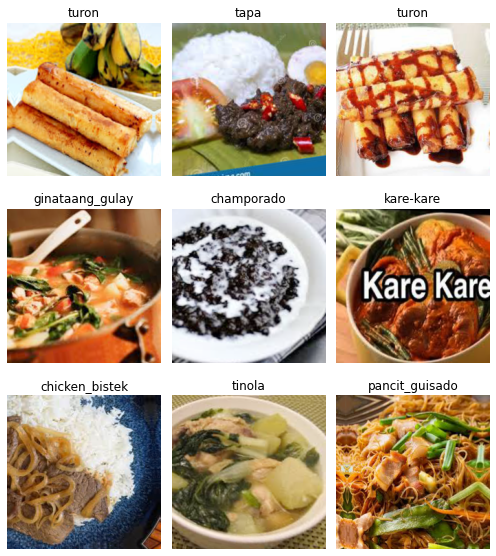

In [4]:
data.show_batch(rows=3, figsize=(7,8))

We create a pre-trained CNN learner with the res-net 152 architecture. Only the last few layers will be unfrozen for us to train to the specific task of classifying Filipino food. This saves a huge amount of time and is called Transfer Learning.

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=True)

We run the learning rate finder which attempts to find a good learning rate range.

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


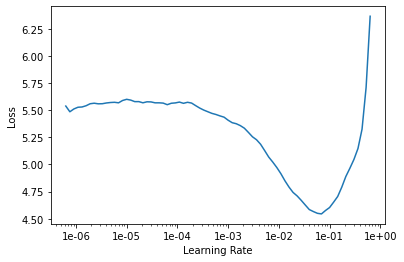

In [8]:
learn.recorder.plot()

From the above plot we want to choose a learning rate which has a steep descent in loss. The graph appears to go steepest downwards around 3e-3 but we can pass in a range of good learning rates below so we choose the steepest portion which appears to be between 2e-3 and 1e-2.

In [9]:
learn.fit_one_cycle(4, max_lr=slice(2e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,3.627437,2.347511,0.556686,00:11
1,2.667643,2.056980,0.488372,00:10
2,2.022697,1.797912,0.462209,00:09
3,1.537802,1.683609,0.415698,00:10


We can see that the training loss is lower than validation loss so we are probably not underfitting. The error rate has decreased to around 42% which is good. It is possible we may be able to reduce it further but we may begin to overfit. We save our progress so that we do not need to retrain if performance decreases and we want to come back to this stage.

In [10]:
learn.save('stage-1')

Again we find a good learning rate, however, first we will unfreeze the model. This allows training on all the layers, not just the last one. 

This time the graph will be much more messy and probably won't have clear steep downward part.

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


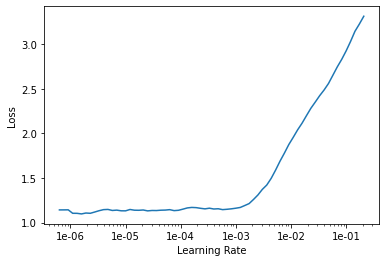

In [13]:
learn.recorder.plot()

We choose values before the sharp upward trajectory where divergence occurs. Remember, now we are training all the layers of the model.

In [14]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.189240,1.647039,0.422965,00:10
1,1.116849,1.605427,0.401163,00:10
2,1.020193,1.574361,0.388081,00:10
3,0.898443,1.572234,0.389535,00:10


We have managed to reduce the error rate a little and it seems to have leveled out. This coupled with the fact the training loss is signifcantly below the validation loss indicates we may be in danger of overfitting. If we train more epochs then we would expect the error rate to creep up as overfitting occurs. Let's save the model and try to overfit by training more epochs.

In [15]:
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


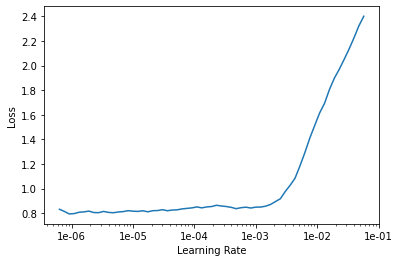

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.875014,2.039433,0.497093,00:10
1,1.217926,2.067722,0.488372,00:10
2,1.034723,1.530892,0.389535,00:10
3,0.746356,1.505744,0.376453,00:10


In [18]:
learn.save('stage-3-unfrozen')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


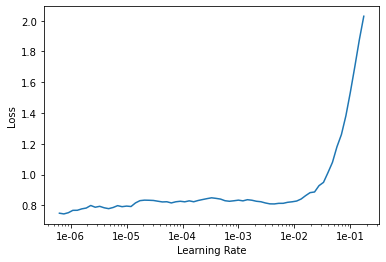

In [19]:
learn.load('stage-2')
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.031266,1.950322,0.468023,00:10
1,1.431365,2.141154,0.465116,00:10
2,1.312193,1.827077,0.427326,00:10
3,1.028178,1.752124,0.430233,00:10


In [21]:
learn.save('stage-3-frozen')

The third stage of training on the unfrozen learner has performed the best.

We can now take a look at the images that the classifer struggled with most and consider removing them from the dataset if they are mislabeled or incorrect.

In [25]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder('data/filipino_food')
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [27]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [28]:
learn_cln.load('stage-3-unfrozen');

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

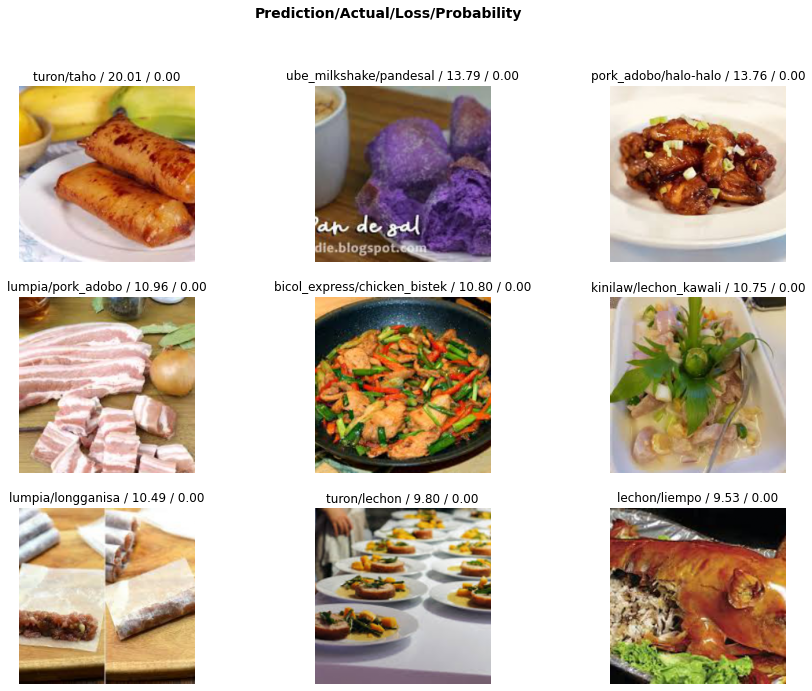

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

The images which had the greatest loss during training show us that the training data contained incorrect images. Most of these are simply mislabeled. We can take these out of the training set and retrain.

In [32]:
interp.most_confused(min_val=3)

[('bistek_talagog', 'chicken_bistek', 9),
 ('chicken_bistek', 'bistek_talagog', 9),
 ('halo-halo', 'ube_milkshake', 5),
 ('pork_adobo', 'kaldereta', 5),
 ('afritada', 'kaldereta', 4),
 ('bibingka', 'cassava_cake', 4),
 ('bulalo', 'pancit_palabok', 4),
 ('kaldereta', 'afritada', 4),
 ('pancit_guisado', 'pancit_palabok', 4),
 ('ube_milkshake', 'halo-halo', 4),
 ('cassava_cake', 'arroz_caldo', 3),
 ('pinakbet', 'afritada', 3),
 ('pork_adobo', 'chicken_adobo', 3),
 ('sinigang', 'tinola', 3),
 ('tapa', 'tocino', 3)]

Above we see the most common confused predicitons. First is the predicted class and second the actual. These make sense as for example, often halo-halo contains ube as an ingredient. Another example is aftritada and kaldereta both being stewed meat with a tomato based sauce.

In [33]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [34]:
ImageCleaner(ds, idxs, 'data/filipino_food')

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Many of the images removed were pictures of the uncooked ingredients going into a dish. Some were simply mislabelled.

We clear out learners from memory as we may have filled the RAM of the GPU.

In [35]:
learn.purge();
learn_cln.purge();

In [36]:
 db = (ImageList.from_csv('data/filipino_food', 'cleaned.csv', folder='.')
                    .split_subsets(train_size=0.8, valid_size=0.2)
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

We can now create a new learner without loading the images which were deleted due to being mislabeled or incorrect and perform the learning process again. Hopefully we will be able to achieve a lower error rate due to having cleaner training data.

In [37]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [38]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


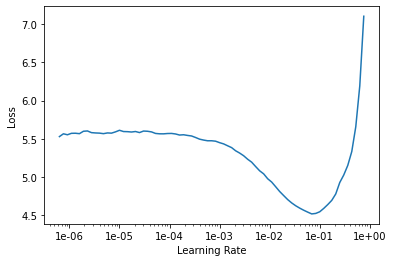

In [39]:
learn_cln.recorder.plot()

In [40]:
learn_cln.fit_one_cycle(4, max_lr=slice(1e-3, 4e-2))

epoch,train_loss,valid_loss,error_rate,time
0,3.522263,3.970654,0.623719,00:08
1,3.111775,2.058623,0.516837,00:08
2,2.228468,1.653531,0.426061,00:08
3,1.681408,1.556836,0.402635,00:08


In [41]:
learn_cln.save('stage-1-cleaned')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


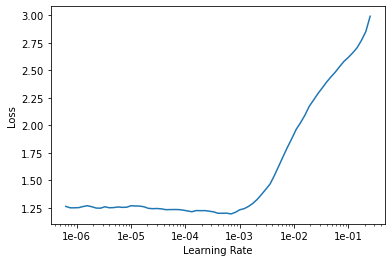

In [42]:
learn_cln.unfreeze()
learn_cln.lr_find()
learn_cln.recorder.plot()

In [43]:
learn_cln.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.329899,1.842073,0.475842,00:10
1,1.321607,1.804600,0.478770,00:10
2,1.067616,1.402914,0.385066,00:10
3,0.817675,1.330916,0.358712,00:10


Unfreezing the layers and training lowered the error rate below 36%. Let's see if we can get it any lower by freezing again and training.

In [44]:
learn_cln.freeze()
learn_cln.save('stage-2-cleaned')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


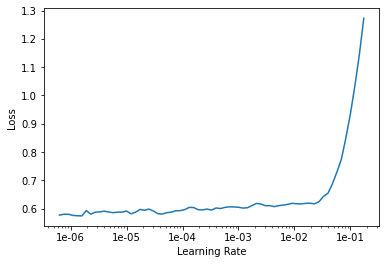

In [45]:
learn_cln.lr_find()
learn_cln.recorder.plot()

In [46]:
learn_cln.fit_one_cycle(4, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.585050,1.429185,0.349927,00:08
1,0.614765,1.604592,0.351391,00:08
2,0.564081,1.550039,0.348463,00:08
3,0.475545,1.531145,0.348463,00:08


It looks like 34.8% is the lowest we can get the error rate. We will export the model from the previous stage as we may be overfitting at this point.

In [47]:
learn_cln.save('stage-3-cleaned')

In [48]:
learn_cln.load('stage-3-cleaned')
learn_cln.export('filipino_food_model_resnet34.pkl')